#References

In [ ]:
#[1] https://www.kaggle.com/code/alexalex02/semantic-segmentation-of-aerial-images
#[2] https://github.com/qubvel/segmentation_models.pytorch/issues/327
#[3] https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
#[4] https://smp.readthedocs.io/_/downloads/en/latest/pdf/
#[5] https://github.com/qubvel/segmentation_models.pytorch/issues/692
#[6] https://github.com/qubvel/segmentation_models.pytorch/issues/147

#Setup

##Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
#upload kaggle token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bennettnewhook","key":"116df93c3e5495f24c1384cc3e581d5d"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!rm -rf kaggle.json

In [ ]:
#NOTE: this is the smaller of the 2 kaggle versions of uavid (4.36GB vs 12.58GB)

!kaggle datasets download -d titan15555/uavid-semantic-segmentation-dataset

100% 3.69G/3.69G [02:06<00:00, 28.6MB/s]
100% 3.69G/3.69G [02:06<00:00, 31.3MB/s]


In [ ]:
!unzip uavid-semantic-segmentation-dataset.zip -d data

Archive:  uavid-semantic-segmentation-dataset.zip
  inflating: data/test/test/seq21/Images/000000.png  
  inflating: data/test/test/seq21/Images/000100.png  
  inflating: data/test/test/seq21/Images/000200.png  
  inflating: data/test/test/seq21/Images/000300.png  
  inflating: data/test/test/seq21/Images/000400.png  
  inflating: data/test/test/seq21/Images/000500.png  
  inflating: data/test/test/seq21/Images/000600.png  
  inflating: data/test/test/seq21/Images/000700.png  
  inflating: data/test/test/seq21/Images/000800.png  
  inflating: data/test/test/seq21/Images/000900.png  
  inflating: data/train/train/seq1/Images/000000.png  
  inflating: data/train/train/seq1/Images/000100.png  
  inflating: data/train/train/seq1/Images/000200.png  
  inflating: data/train/train/seq1/Images/000300.png  
  inflating: data/train/train/seq1/Images/000400.png  
  inflating: data/train/train/seq1/Images/000500.png  
  inflating: data/train/train/seq1/Images/000600.png  
  inflating: data/train/t

In [ ]:
!rm -rf /content/uavid-semantic-segmentation-dataset.zip

##Packages

In [ ]:
!pip install torch
!pip install segmentation-models-pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12422 sha256=9b3519a2c771d3806e3ed37165a05618098dcd1ff1b6d03b73aca6f4ba4c513a
  Stored in directory: /root/.cache/pip/wheels/6b/48/d7/9a3ea4072e0d735f895d5e58f9a679903dcb4e90a55418955b
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=38f4f5ebaa0b017805b349006755a20a9464d4cb3e10cc57256d5671d1946eb8
  Stored in directory: /

#Data

##Overview

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

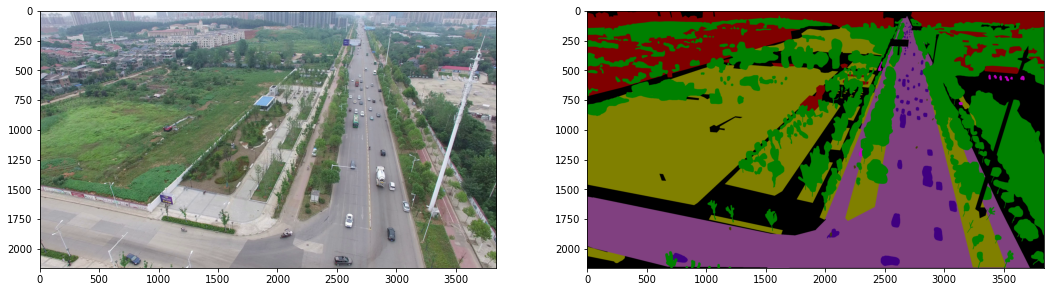

In [ ]:
#[1]
def example(image_path = './data/train/train/seq33/Images/000200.png',
             mask_path ='./data/train/train/seq33/Labels/000200.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    plt.figure(figsize=(18, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
example()

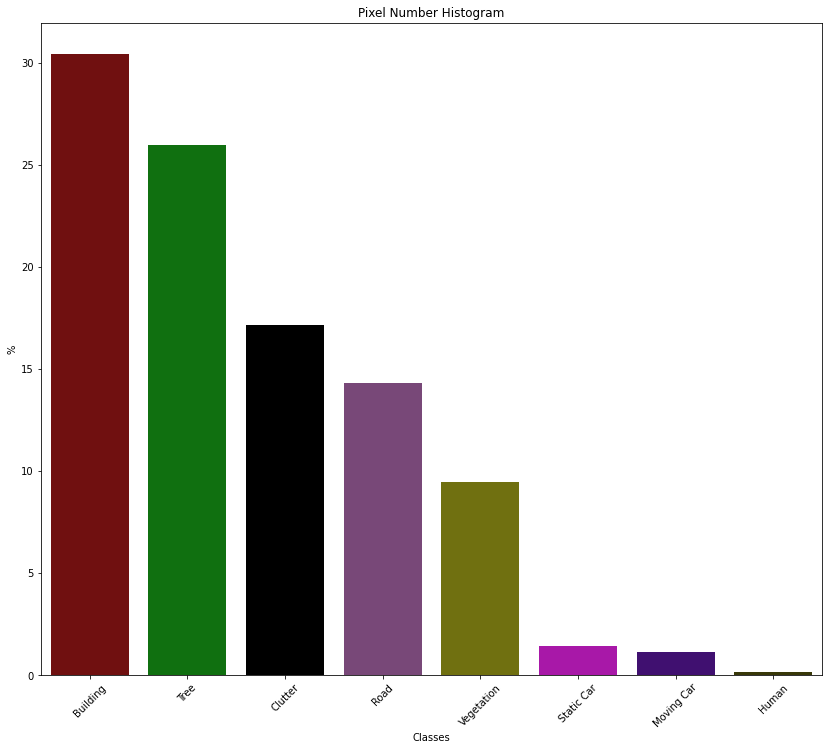

In [ ]:
#[1]
import pandas as pd
import seaborn as sns
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation', 'Static Car', 'Moving Car', 'Human']
pixels = [30.436, 25.977, 17.120, 14.322, 9.464, 1.405, 1.115, 0.162]
pix = pd.DataFrame({'Classes': cls, 'Pixel Number': pixels})

def plot_pixel():
    plt.figure(figsize=(14,12))
    sns.set_palette(['#800000','#008000','#000000', '#804080', '#808000', '#C000C0', '#400080', '#404000'])
    sns.barplot(x='Classes', y='Pixel Number', data=pix)
    plt.title('Pixel Number Histogram')
    plt.ylabel('%')
    plt.xticks(rotation=45)

plot_pixel()

##Preparation

In [ ]:
#[1]
import numpy as np

class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self):
        clr_tab = {}
        clr_tab['Clutter'] = [0, 0, 0]
        clr_tab['Building'] = [128, 0, 0]
        clr_tab['Road'] = [128, 64, 128]
        clr_tab['Static_Car'] = [192, 0, 192]
        clr_tab['Tree'] = [0, 128, 0]
        clr_tab['Vegetation'] = [128, 128, 0]
        clr_tab['Human'] = [64, 64, 0]
        clr_tab['Moving_Car'] = [64, 0, 128]
        return clr_tab

    def colorTable(self):
        return self.clr_tab

    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

clrEnc = UAVidColorTransformer()

In [ ]:
#[1]
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'
import os.path as osp


def prepareTrainIDForDir(gtDirPath, saveDirPath):
    gt_paths = [p for p in os.listdir(gtDirPath) if p.startswith('seq')]
    for pd in tqdm(gt_paths):
        lbl_dir = osp.join(gtDirPath, pd, 'Labels')
        lbl_paths = os.listdir(lbl_dir)
        if not osp.isdir(osp.join(saveDirPath, pd, 'TrainId')):
            os.makedirs(osp.join(saveDirPath, pd, 'TrainId'))
            assert osp.isdir(osp.join(saveDirPath, pd, 'TrainId')), 'Fail to create directory:%s'%(osp.join(saveDirPath, pd, 'TrainId'))
        for lbl_p in lbl_paths:
            lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
            trainId_path = osp.join(saveDirPath, pd, 'TrainId', lbl_p)
            gt = np.array(Image.open(lbl_path))
            trainId = clrEnc.transform(gt, dtype=np.uint8)
            Image.fromarray(trainId).save(trainId_path)

In [ ]:
#[1]
from tqdm import tqdm

prepareTrainIDForDir('./data/train/train', './trainlabels/')
prepareTrainIDForDir('./data/valid/valid', './validlabels/')

100%|██████████| 7/7 [00:29<00:00,  4.27s/it]


In [ ]:
#[1]
import glob

train_image_list = sorted(glob.glob(pathname='./data/train/train/*/Images/*.png', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/*/TrainId/*.png', recursive=True))
valid_image_list = sorted(glob.glob(pathname='./data/valid/valid/*/Images/*.png', recursive=True))
valid_mask_list =  sorted(glob.glob(pathname='./validlabels/*/TrainId/*.png', recursive=True))

print(train_image_list[42])
print(train_mask_list[42])

##Create Dataset Object

In [ ]:
#[1]
import torch

SEED = 42
torch.manual_seed(SEED)

In [ ]:
#[1]
import cv2

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):

    CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']

    def __init__(
            self,
            images_list,
            masks_list,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes

        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255

        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_list)

###Visualization Helper Functions

In [ ]:
#[1]
def visualize1(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

#[3]
# helper function for data visualization
def visualize2(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

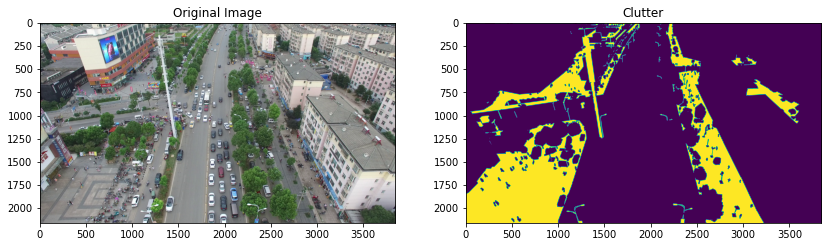

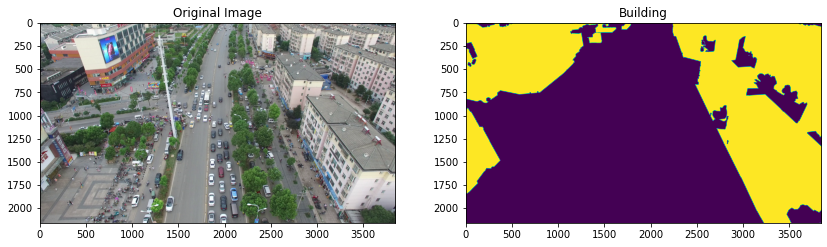

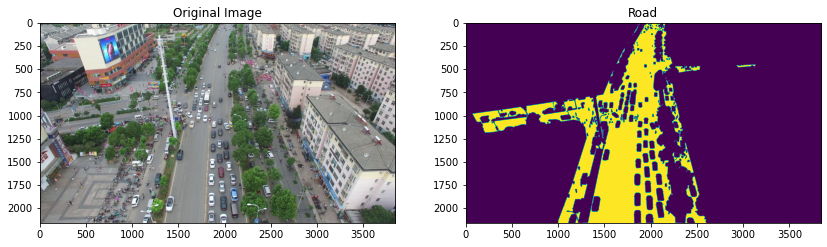

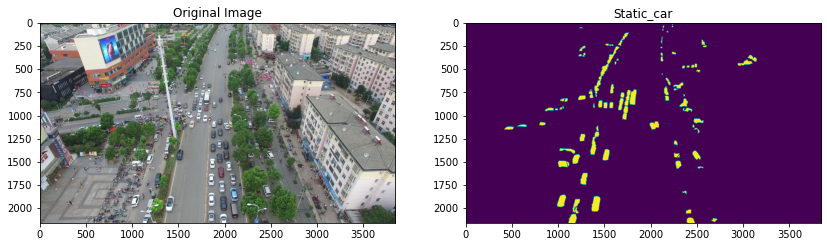

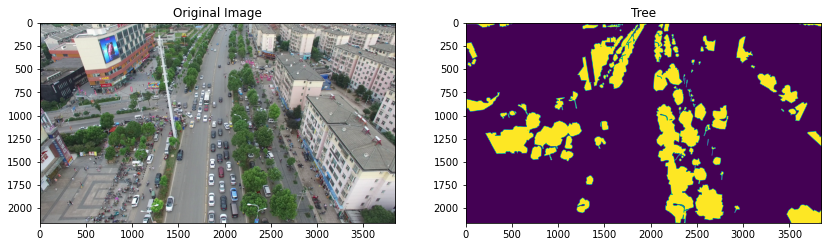

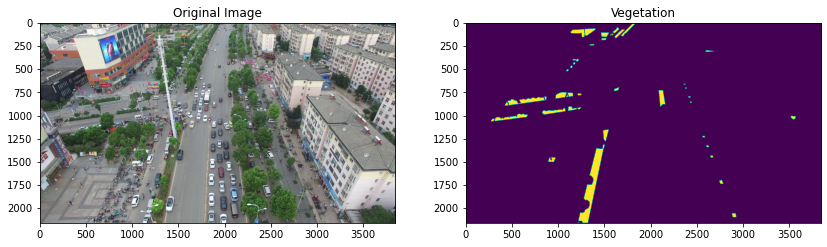

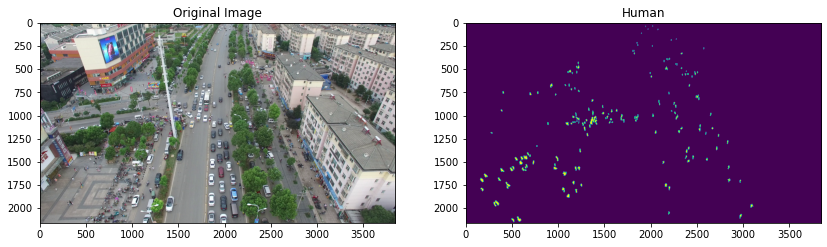

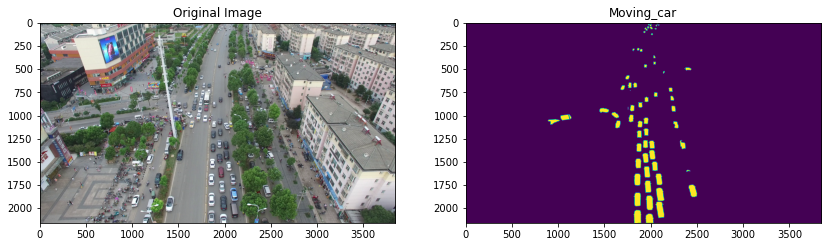

In [ ]:
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])

    image, mask = dataset[4]
    visualize1(
        image=image, mask=mask.squeeze(),
        label = label)

###Apply Augmentations

We'll resize images to 576*1024 to keep 9:16 ratio.

Augmentation list:

    HorizontalFlip
    OneOf(RandomBrightnessContrast, CLAHE, HueSaturationValue)
    IAAAdditiveGaussianNoise with 0.2 probability

Note: For better result we could crop each image into 16 evenly distributed smaller(1280*720) overlapped images that cover the whole image for training.

In [ ]:
#[1]
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


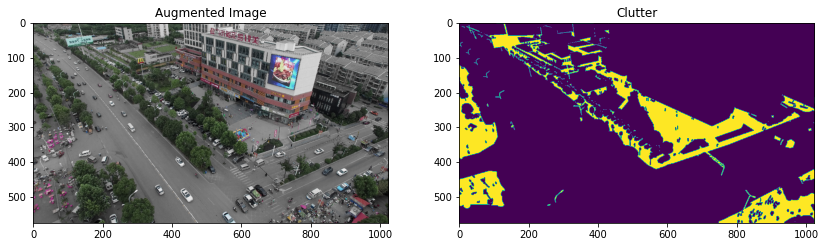

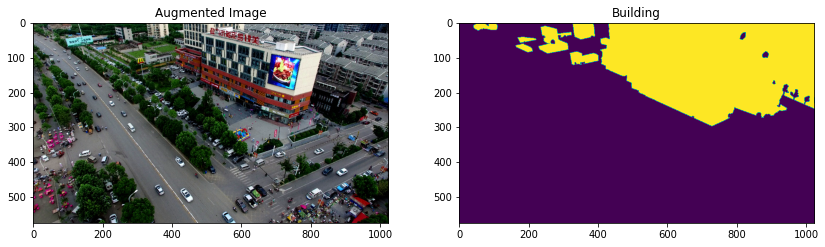

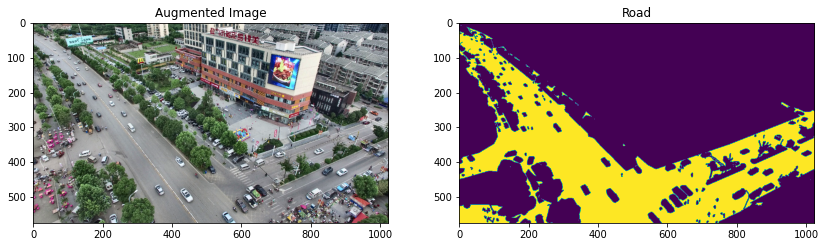

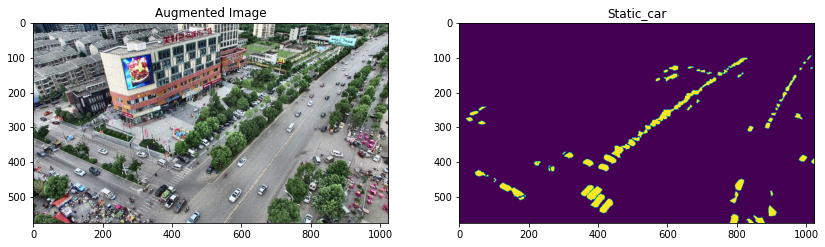

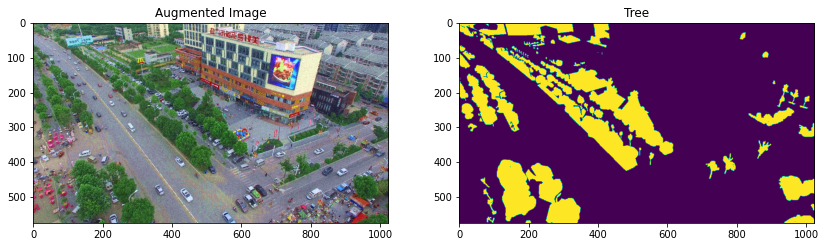

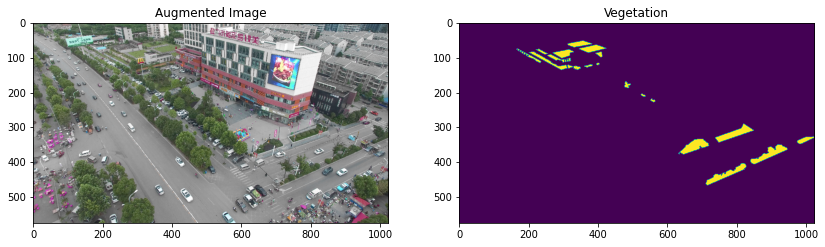

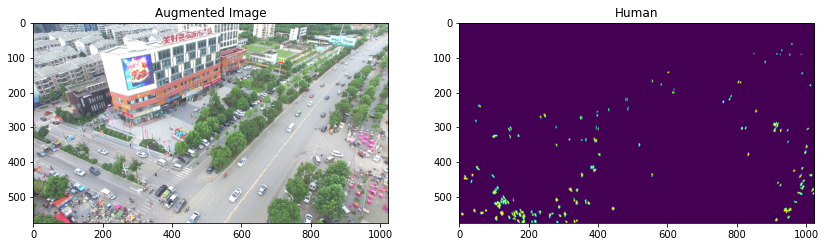

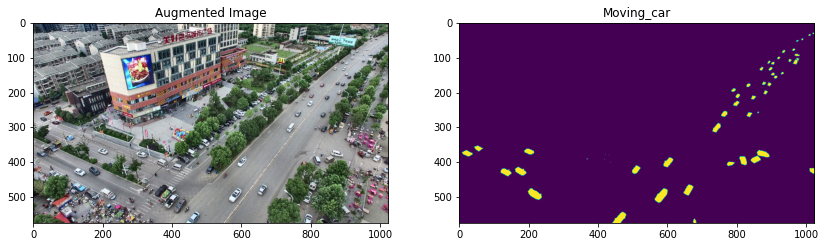

In [ ]:
#[1]
#Visualizing augmented images and masks
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list,
        train_mask_list,
        augmentation=get_training_augmentation(),
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[8]
    visualize1(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

#Model Creation

In [ ]:
#[1]
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

In [ ]:
#[1]
batch_size = 32

train_dataset = Dataset(
    train_image_list,
    train_mask_list,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valid_image_list,
    valid_mask_list,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


In [ ]:
#[3]
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

#[4]
#[2]
metrics = [smp.utils.metrics.IoU(threshold=0.5),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[1,2,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,2,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6]),
]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

train_epoch.metrics[1].__name__="IoU_clutter"
train_epoch.metrics[2].__name__="IoU_building"
train_epoch.metrics[3].__name__="IoU_road"
train_epoch.metrics[4].__name__="IoU_static_car"
train_epoch.metrics[5].__name__="IoU_tree"
train_epoch.metrics[6].__name__="IoU_vegetation"
train_epoch.metrics[7].__name__="IoU_human"
train_epoch.metrics[8].__name__="IoU_moving_car"

In [ ]:
# train model for 40 epochs

epochs = 5

max_score = 0

# for i in range(0, 40):

for i in range(0, epochs+1):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train:   0%|          | 0/6 [00:36<?, ?it/s]


OutOfMemoryError: ignored

#Test Best Saved Model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
#[3]
# evaluate model on val set, as there is no annotated test set
# there is code to create the test dataset object, should you find an annotated test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,ses a Generative Adversarial Network (GAN) to generate realistic images that are conditioned on cue images and segmentation maps, as shown below (image source):
    device=DEVICE,
)

logs = test_epoch.run(valid_loader)

#Visualize Predictions

In [ ]:
#[3]
# test dataset without transformations for image visualization
valid_dataset_vis = Dataset(
    valid_image_list, valid_mask_list,
    classes=CLASSES,
)

In [ ]:
#[3]
def combine_masks(masks):
  # masks should be size (channels, w, h)
  output_mask = np.zeros(masks[0].shape, dtype=np.uint8)

  for i, mask in enumerate(masks):
    output_mask[mask==1] = i + 1

  return output_mask

In [ ]:
#[6]

test_dataset = valid_dataset
test_dataset_vis = valid_dataset_vis

for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize2(
        image=image_vis,
        ground_truth_mask=combine_masks(gt_mask),
        predicted_mask=combine_masks(pr_mask)
    )